Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from functools import reduce
from statsmodels.tsa.seasonal import seasonal_decompose

Загрузка данных

In [3]:
file_paths = {
    "train": "../data/train.xlsx",
    "test": "../data/test.xlsx",
    "cargo": "../data/Грузоперевозки.xlsx",
    "market_data": "../data/Данные рынка стройматериалов.xlsx",
    "index_LME": "../data/Индекс LME.xlsx",
    "macro": "../data/Макропоказатели.xlsx",
    "metal_market": "../data/Показатели рынка металла.xlsx",
    "fuel": "../data/Топливо.xlsx",
    "material_price": "../data/Цены на сырье.xlsx"
}

dataframes = {name: pd.read_excel(path) for name, path in file_paths.items()}

Сохранение в CSV

In [4]:
csv_paths = {name: path.replace("../data/", "../csvs/").replace(".xlsx", ".csv") for name, path in file_paths.items()}
for name, df in dataframes.items():
    df.to_csv(csv_paths[name], sep=",", index=False)

Объединение train и test

In [5]:
train = pd.concat([dataframes["train"], dataframes["test"]], ignore_index=True)
train.to_csv("../data/price_data.csv", index=False)

dataframes.pop("test")  # test больше не нужен отдельно

dataframes["index_LME"]["цена"] = pd.to_numeric(dataframes["index_LME"]["цена"], errors='coerce')
dataframes["index_LME"].dropna(subset=["цена"], inplace=True)
dataframes["index_LME"].rename(columns={"дата": "dt"}, inplace=True)

Преобразование dt

In [6]:
for name, df in dataframes.items():
    df["dt"] = pd.to_datetime(df["dt"], format='%Y-%m-%d', errors='coerce')
    dataframes[name] = df.set_index("dt").resample("W-MON").mean().reset_index()

Определение общих границ дат

In [7]:
min_date = max(df["dt"].min() for df in dataframes.values())
max_date = min(df["dt"].max() for df in dataframes.values())

dataframes = {name: df[(df["dt"] >= min_date) & (df["dt"] <= max_date)].reset_index(drop=True) for name, df in dataframes.items()}

Объединение данных по dt

In [8]:
df_merged = reduce(lambda left, right: pd.merge(left, right, on='dt', how='inner'), dataframes.values())
df_merged.set_index("dt", inplace=True)
df_merged.to_csv("df_merged1.csv")

Очистка данных

In [9]:
df_cleaned = df_merged.dropna(axis=1, how='all')
df_cleaned.interpolate(method='linear', inplace=True)
df_cleaned.dropna(axis=1, inplace=True)
df_cleaned = df_cleaned.loc[:, (df_cleaned == 0.0).mean() <= 0.8]

C:\Users\User\AppData\Local\Temp\ipykernel_9784\3597007761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.interpolate(method='linear', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_9784\3597007761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.dropna(axis=1, inplace=True)


Проверка стационарности

In [10]:
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

Графики до обработки

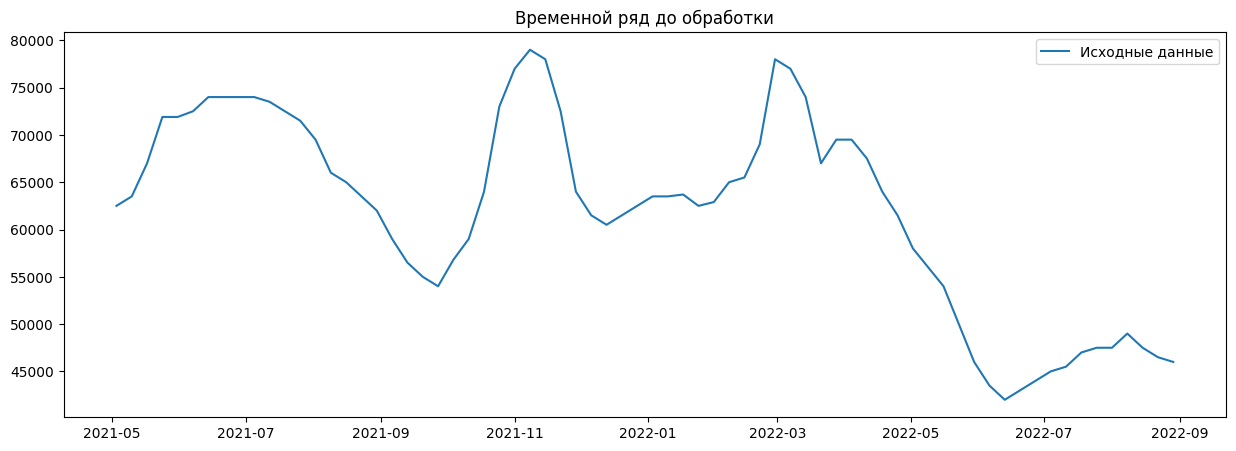

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(df_cleaned["Цена на арматуру"], label="Исходные данные")
plt.legend()
plt.title("Временной ряд до обработки")
plt.show()

Разложение на тренд, сезонность и остатки

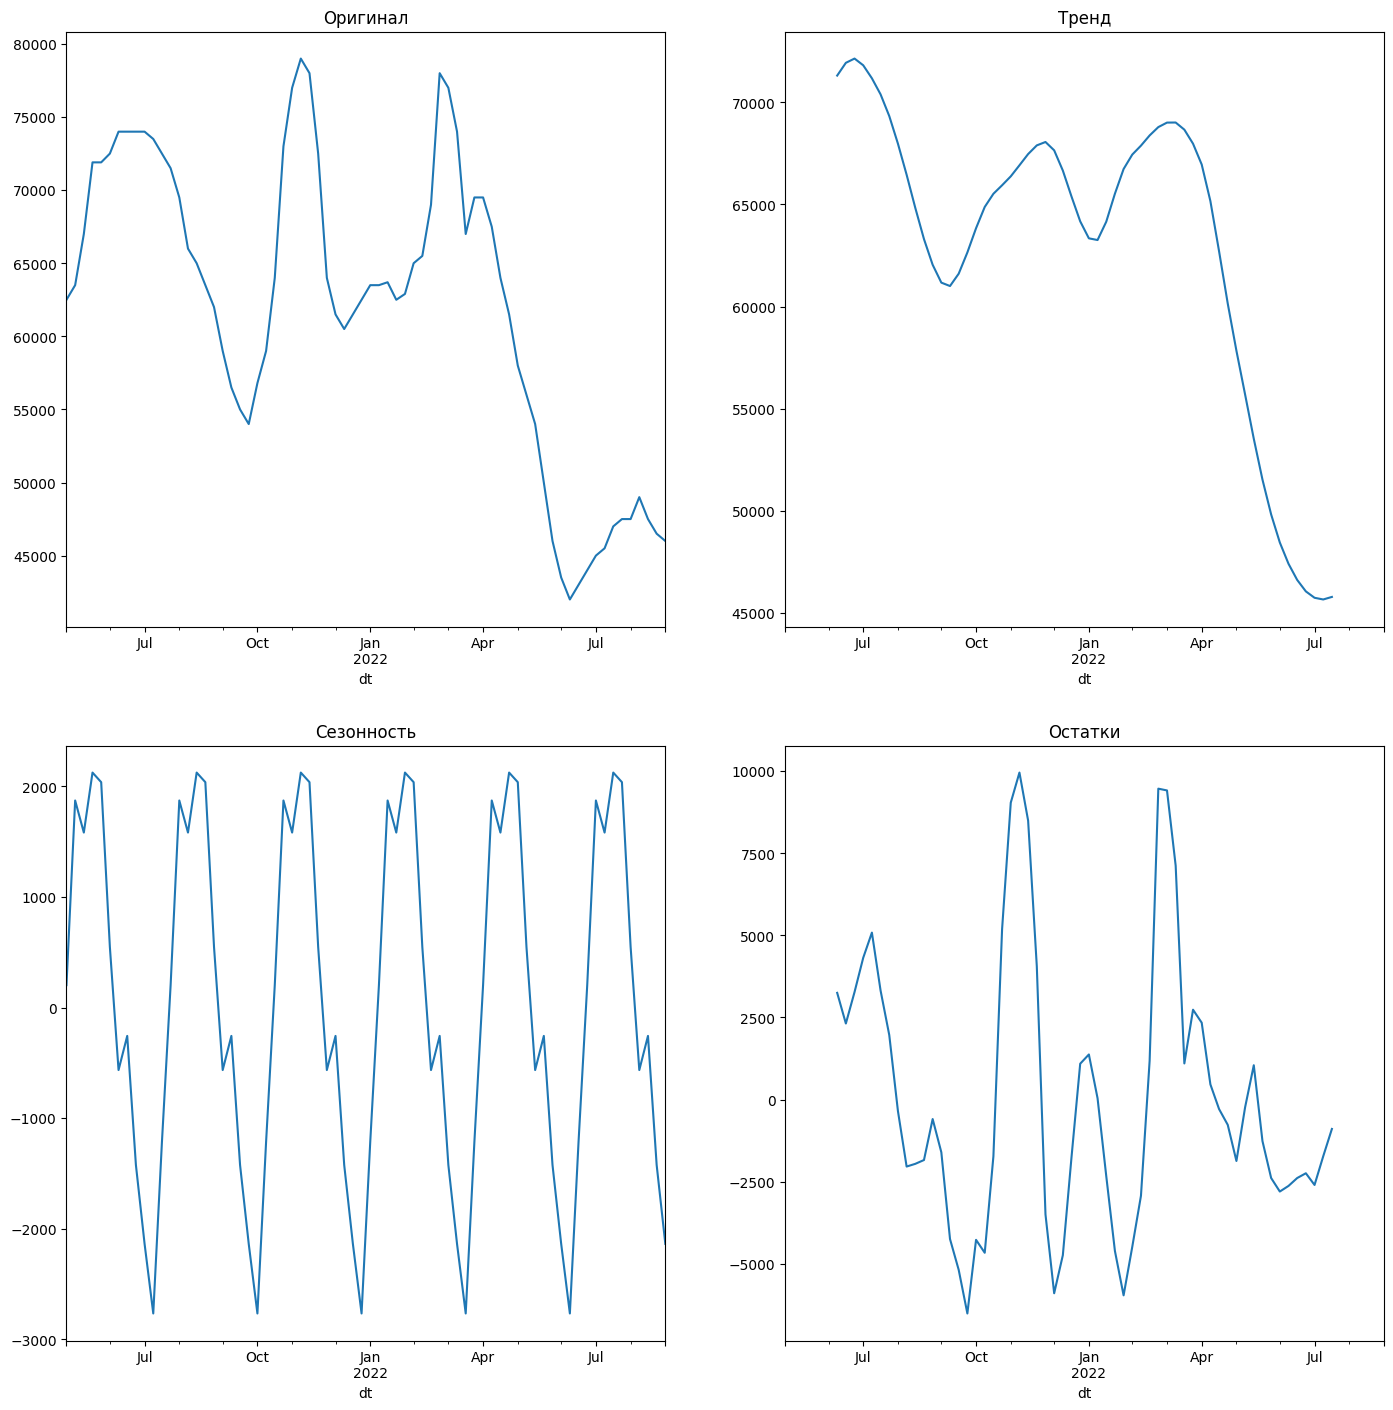

In [12]:
decompose = seasonal_decompose(df_cleaned["Цена на арматуру"], period=12)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 17))
ax[0, 0].set_title("Оригинал")
ax[0, 1].set_title("Тренд")
ax[1, 0].set_title("Сезонность")
ax[1, 1].set_title("Остатки")
decompose.observed.plot(ax=ax[0, 0])
decompose.trend.plot(ax=ax[0, 1])
decompose.seasonal.plot(ax=ax[1, 0])
decompose.resid.plot(ax=ax[1, 1])
plt.show()

Проверка стационарности до обработки

ADF Statistic: -2.0526466251504756
p-value: 0.26397668064242247


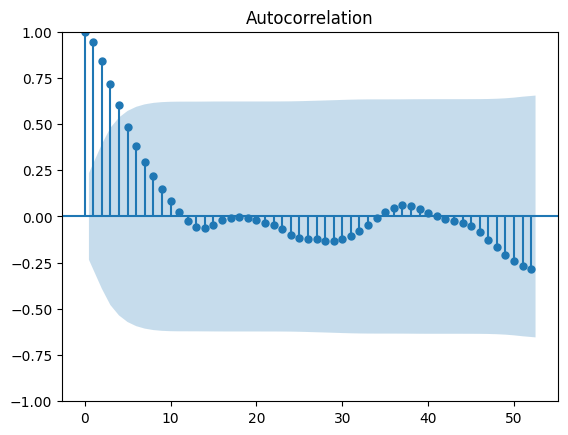

In [13]:
check_stationarity(df_cleaned["Цена на арматуру"])
plot_acf(df_cleaned["Цена на арматуру"], lags=52)
plt.show()

Гистограмма данных до обработки

Преобразования для стационарности

In [15]:
df_cleaned.rename(columns={"Цена на арматуру": "price"}, inplace=True)
df_cleaned["price_diff"] = df_cleaned["price"].diff()
df_cleaned["price_seasonal_diff"] = df_cleaned["price"].diff(12)
df_cleaned.dropna(inplace=True)

Проверка стационарности после обработки

ADF Statistic: -3.891176265720835
p-value: 0.0021007531756333966


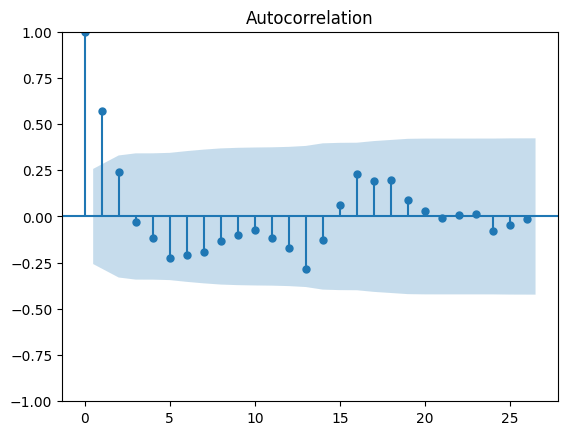

In [16]:
check_stationarity(df_cleaned["price_diff"])
plot_acf(df_cleaned["price_diff"], lags=26)
plt.show()

Гистограмма данных после обработки

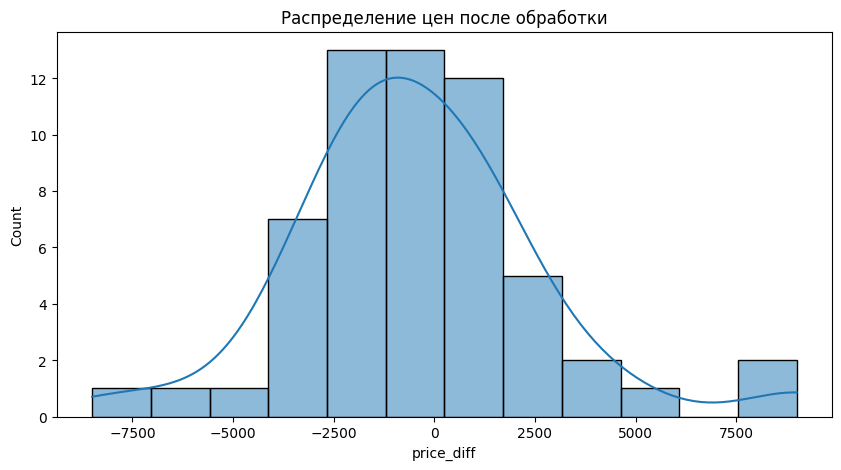

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned["price_diff"], kde=True)
plt.title("Распределение цен после обработки")
plt.show()

Сохранение итогового файла

In [18]:
output_path = "../data/processed_data.xlsx"
df_cleaned.to_excel(output_path, index=True)
print(f"Файл сохранен: {output_path}")

Файл сохранен: ../data/processed_data.xlsx
